In [1]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision.datasets import CIFAR10

In [2]:
DATA_DIR = 'data/'
CATEGORIES = ['aviao', 'automovel', 'passaro', 'gato', 'cervo',
              'cachorro','sapo', 'cavalo', 'navio', 'caminhao']

In [3]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

100.0%


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [4]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [5]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item() # pega uma amostra aleatória no dataset
      img, label = dataset[sample_idx] # label = classe. Basicamente o que é a imagem, se é um carro, gato, etc.
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()


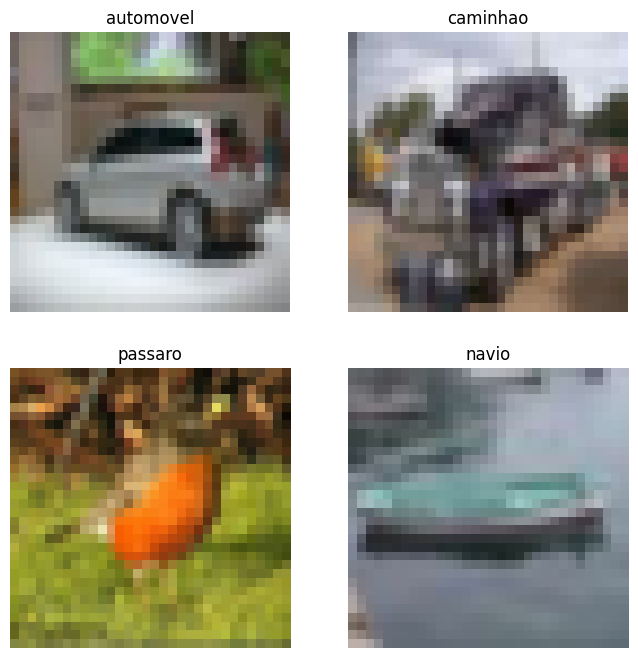

In [7]:
lookat_dataset(cifar10_train)

Pre-processando os dados


In [9]:
import torchvision.transforms as T

In [10]:
prep_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        )
    ]
)
tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform=prep_transform)

In [11]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [12]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [13]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


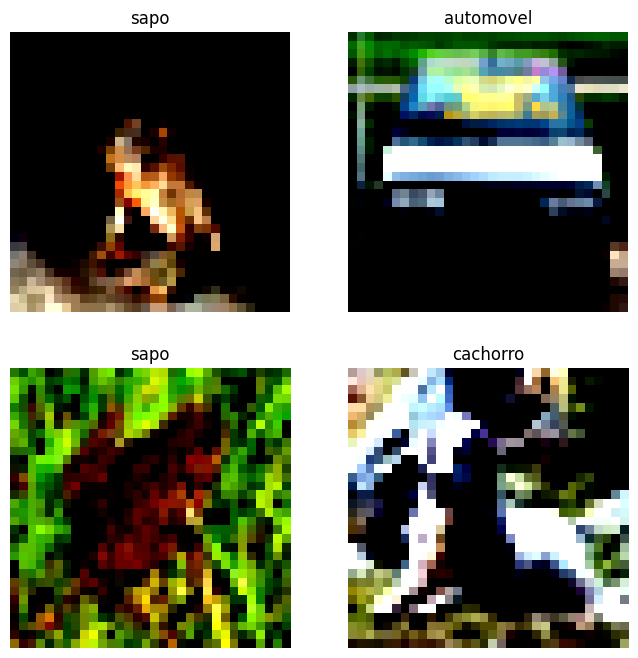

In [15]:
lookat_dataset(tensor_train, True)

In [16]:
from torch.utils.data import DataLoader

In [17]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

# Construindo uma MLP
MLP = Multilayer Perceptron

In [18]:
from torch import nn
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(32 * 32 * 3, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [21]:
model = MLPClassifier().to(device)

Escolhendo os hiperparâmetros da otimização


In [22]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [23]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [24]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs Iteartions", fontsize="16")

In [25]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2901035013711057
Epoch: 10; Train Loss: 1.8541079771793103
Epoch: 20; Train Loss: 1.6468255111323598
Epoch: 30; Train Loss: 1.5182603538188788


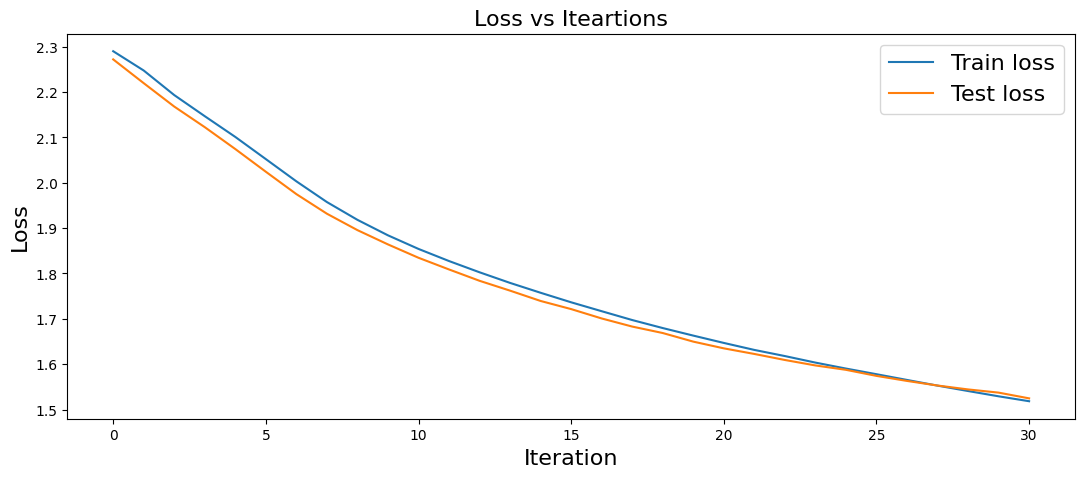

In [27]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

# Avaliando o resultado

In [1]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))


In [25]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class aviao is: 50.3 %
Accuracy for class automovel is: 60.0 %
Accuracy for class passaro is: 30.5 %
Accuracy for class gato  is: 27.7 %
Accuracy for class cervo is: 29.1 %
Accuracy for class cachorro is: 37.3 %
Accuracy for class sapo  is: 60.0 %
Accuracy for class cavalo is: 52.0 %
Accuracy for class navio is: 63.9 %
Accuracy for class caminhao is: 50.2 %
Global acccuracy is 46.1


In [26]:
import seaborn as sn

<Axes: >

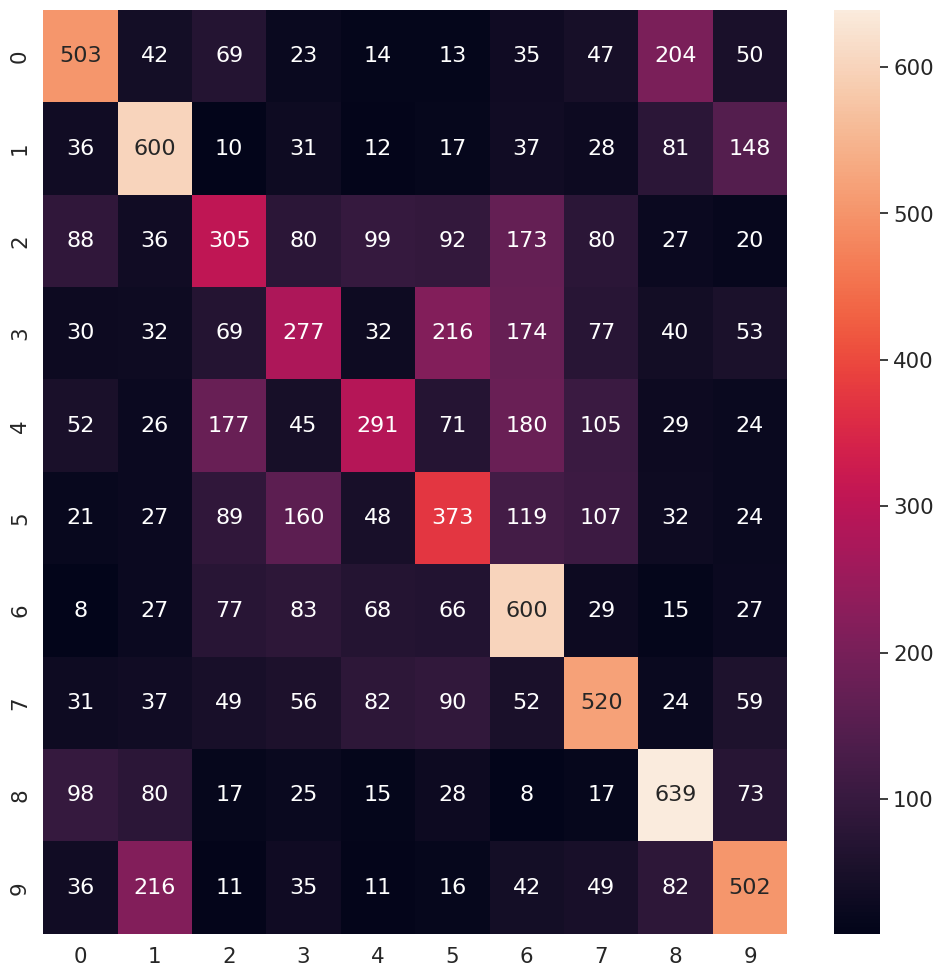

In [27]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

In [39]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )

    self.linearlayers = nn.Sequential(
        nn.Linear(1152, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
    # aprene as features
    x = self.convlayers(x)
    x = torch.flatten(x, 1)
    return self.linearlayers(x)

In [40]:
convmodel = ConvolutionalModel().to(device)

In [41]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr=1e-3)
convlossfunc = nn.CrossEntropyLoss()

In [42]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, convlossfunc, conv_optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, convlossfunc)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2981466978712155
Epoch: 10; Train Loss: 1.7691760967149759
Epoch: 20; Train Loss: 1.475559545904779
Epoch: 30; Train Loss: 1.3264360038368292


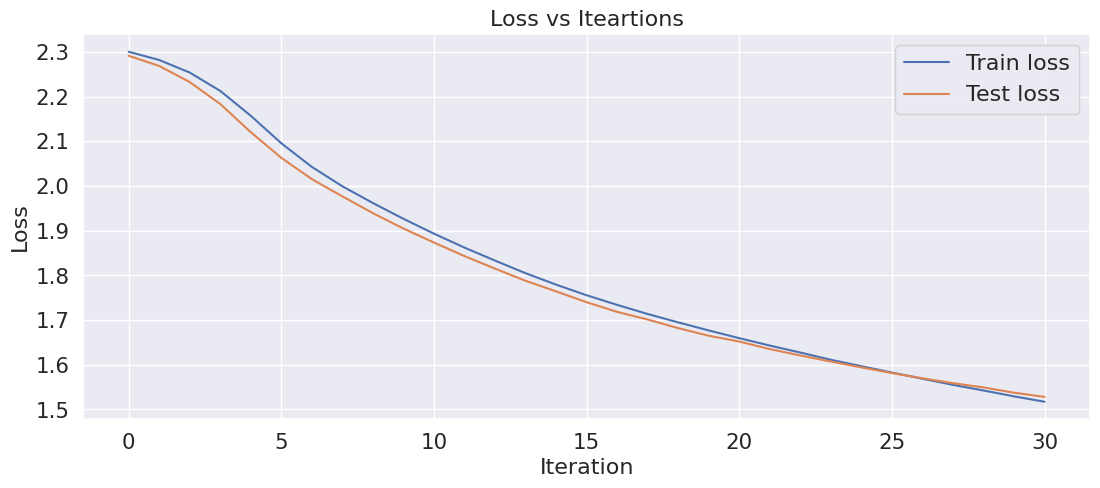

In [43]:
convlosses = {"Train loss": train_loss, "Test loss": test_losses}
plot_losses(losses)

In [44]:
conv_confusion_matrix = evaluate_accuracy(
    convmodel,
    test_loader,
    CATEGORIES
)

Accuracy for class aviao is: 53.6 %
Accuracy for class automovel is: 66.8 %
Accuracy for class passaro is: 33.5 %
Accuracy for class gato  is: 38.8 %
Accuracy for class cervo is: 35.8 %
Accuracy for class cachorro is: 40.6 %
Accuracy for class sapo  is: 63.1 %
Accuracy for class cavalo is: 67.8 %
Accuracy for class navio is: 63.2 %
Accuracy for class caminhao is: 61.4 %
Global acccuracy is 52.5


<Axes: >

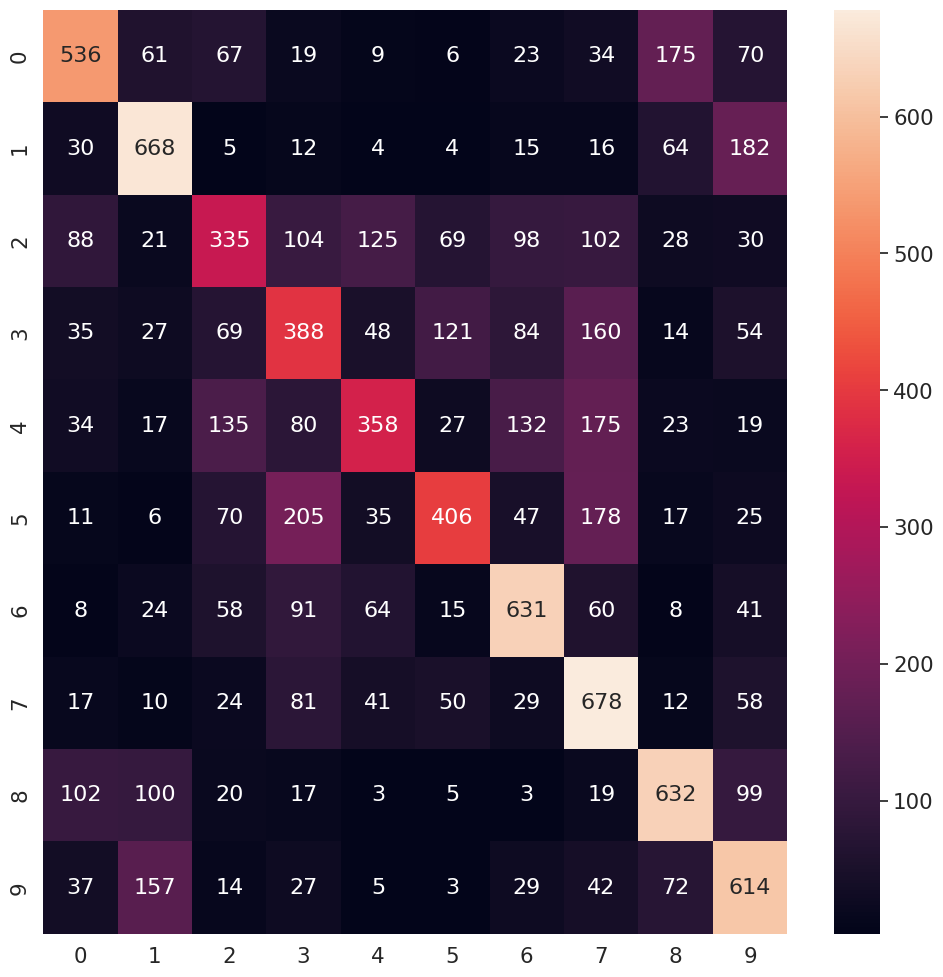

In [45]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(conv_confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')